In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
import matplotlib.pyplot as plt
import numpy as np
from tqdm import tqdm

# Configuration
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
BATCH_SIZE = 128
LR = 1e-4
EPOCHS = 5 # Augmenter pour de meilleurs résultats (ex: 20-50)
TIMESTEPS = 500 # Nombre d'étapes de diffusion
IMG_SIZE = 28
CHANNELS = 1

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.0/8.0 MB 18.4 MB/s  0:00:00 eta 0:00:01

[notice] A new release of pip is available: 25.2 -> 25.3
[notice] To update, run: pip install --upgrade pip


100%|██████████| 9.91M/9.91M [00:01<00:00, 9.32MB/s]
100%|██████████| 28.9k/28.9k [00:00<00:00, 318kB/s]
100%|██████████| 1.65M/1.65M [00:00<00:00, 2.96MB/s]
100%|██████████| 4.54k/4.54k [00:00<00:00, 6.72MB/s]


Shape du batch : torch.Size([128, 1, 28, 28])


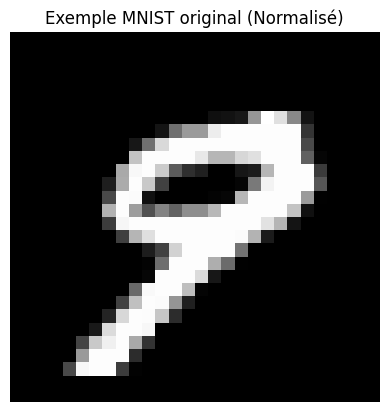

In [3]:
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Lambda(lambda t: (t * 2) - 1)
])

dataset = datasets.MNIST(root='./data', train=True, download=True, transform=transform)
dataloader = DataLoader(dataset, batch_size=BATCH_SIZE, shuffle=True, drop_last=True)

image, _ = next(iter(dataloader))
print(f"Shape du batch : {image.shape}")
plt.imshow(image[0, 0].cpu(), cmap='gray')
plt.title("Exemple MNIST original (Normalisé)")
plt.axis('off')
plt.show()

In [4]:
class DiffusionUtils:
    def __init__(self, timesteps=TIMESTEPS, start=0.0001, end=0.02, device=DEVICE):
        self.timesteps = timesteps
        self.device = device
        
        self.betas = torch.linspace(start, end, timesteps).to(device)
        self.alphas = 1. - self.betas
        self.alphas_cumprod = torch.cumprod(self.alphas, axis=0)
        
    def forward_noise(self, x_0, t):
        """
        Ajoute du bruit à l'image x_0 à l'instant t.
        Retourne : l'image bruitée (x_t) et le bruit ajouté (noise)
        """
        sqrt_alphas_cumprod = torch.sqrt(self.alphas_cumprod[t])[:, None, None, None]
        sqrt_one_minus_alphas_cumprod = torch.sqrt(1. - self.alphas_cumprod[t])[:, None, None, None]
        
        noise = torch.randn_like(x_0)
        return sqrt_alphas_cumprod * x_0 + sqrt_one_minus_alphas_cumprod * noise, noise

    def sample_timesteps(self, n):
        """Retourne des indices de temps aléatoires pour le training"""
        return torch.randint(0, self.timesteps, (n,), device=self.device)

diff_utils = DiffusionUtils()

In [5]:
class TimeEmbedding(nn.Module):
    def __init__(self, n_embd):
        super().__init__()
        self.n_embd = n_embd
        self.lin1 = nn.Linear(self.n_embd // 4, self.n_embd)
        self.lin2 = nn.Linear(self.n_embd, self.n_embd)

    def forward(self, t):
        # Encodage sinusoïdal simple (positional encoding)
        half_dim = self.n_embd // 8
        emb = torch.log(torch.tensor(10000.0)) / (half_dim - 1)
        emb = torch.exp(torch.arange(half_dim, device=t.device) * -emb)
        emb = t[:, None] * emb[None, :]
        emb = torch.cat((emb.sin(), emb.cos()), dim=1)
        return self.lin2(F.silu(self.lin1(emb)))

class SimpleUNet(nn.Module):
    def __init__(self):
        super().__init__()
        # Time embedding
        time_dim = 32
        self.time_mlp = TimeEmbedding(time_dim)

        # Encoder (Down)
        self.conv1 = nn.Conv2d(1, 32, 3, padding=1) # 28x28
        self.conv2 = nn.Conv2d(32, 64, 3, stride=2, padding=1) # 14x14
        self.conv3 = nn.Conv2d(64, 128, 3, stride=2, padding=1) # 7x7

        # Bottleneck
        self.bot1 = nn.Conv2d(128, 256, 3, padding=1)
        self.bot2 = nn.Conv2d(256, 128, 3, padding=1)

        # Decoder (Up)
        self.up1 = nn.ConvTranspose2d(128, 64, 4, stride=2, padding=1) # 14x14
        self.up2 = nn.ConvTranspose2d(64, 32, 4, stride=2, padding=1) # 28x28
        self.out = nn.Conv2d(32, 1, 3, padding=1)

    def forward(self, x, t):
        # Gestion du temps
        t_emb = self.time_mlp(t)
        # Projection du temps pour qu'il matche les dimensions des channels (broadcasting)
        t_emb_1 = t_emb[:, :, None, None] 
        
        # --- Encoder ---
        x1 = F.relu(self.conv1(x))
        x2 = F.relu(self.conv2(x1))
        x3 = F.relu(self.conv3(x2))

        # --- Bottleneck ---
        x_bot = F.relu(self.bot1(x3))
        x_bot = F.relu(self.bot2(x_bot))
        
        # --- Decoder (avec Skip Connections simplifiées par addition ici) ---
        # Note: Pour un vrai U-Net rigoureux on concatène, ici on additionne pour simplifier le code
        x_up1 = F.relu(self.up1(x_bot + x3)) 
        x_up2 = F.relu(self.up2(x_up1 + x2))
        
        return self.out(x_up2 + x1)

model = SimpleUNet().to(DEVICE)
optimizer = torch.optim.Adam(model.parameters(), lr=LR)
criterion = nn.MSELoss()
print("Modèle U-Net chargé.")

Modèle U-Net chargé.


In [ ]:
losses = []

for epoch in range(EPOCHS):
    pbar = tqdm(dataloader, desc=f"Epoch {epoch+1}/{EPOCHS}")
    for batch in pbar:
        optimizer.zero_grad()
        
        images, _ = batch
        images = images.to(DEVICE)
        
        # 1. Échantillonner t
        t = diff_utils.sample_timesteps(images.shape[0]).float() # float pour l'embedding
        
        # 2. Créer l'image bruitée (x_t) et garder le bruit cible (noise)
        x_t, noise = diff_utils.forward_noise(images, t.long())
        
        # 3. Prédiction du bruit
        noise_pred = model(x_t, t)
        
        # 4. Calcul de la perte (MSE entre le vrai bruit et le bruit prédit)
        loss = criterion(noise_pred, noise)
        
        loss.backward()
        optimizer.step()
        
        pbar.set_postfix(MSE=loss.item())
        losses.append(loss.item())

plt.plot(losses)
plt.title("Courbe de Loss")
plt.show()

In [ ]:
@torch.no_grad()
def sample_images(model, diff_utils, n_samples=8):
    model.eval()
    
    # On commence avec du bruit pur (Gaussian noise)
    x = torch.randn((n_samples, 1, IMG_SIZE, IMG_SIZE)).to(DEVICE)
    
    # Boucle inversée : de T-1 jusqu'à 0
    for i in tqdm(reversed(range(1, TIMESTEPS)), desc="Sampling", total=TIMESTEPS-1):
        t = (torch.ones(n_samples) * i).long().to(DEVICE)
        
        # Le modèle prédit le bruit à retirer
        predicted_noise = model(x, t.float()) # t float pour l'embedding
        
        # Formule de sampling (simplifiée DDPM)
        alpha = diff_utils.alphas[t][:, None, None, None]
        alpha_hat = diff_utils.alphas_cumprod[t][:, None, None, None]
        beta = diff_utils.betas[t][:, None, None, None]
        
        if i > 1:
            noise = torch.randn_like(x)
        else:
            noise = torch.zeros_like(x)
            
        # On retire une partie du bruit
        x = (1 / torch.sqrt(alpha)) * (x - ((1 - alpha) / (torch.sqrt(1 - alpha_hat))) * predicted_noise) + torch.sqrt(beta) * noise
        
    model.train()
    
    # On remet les pixels entre 0 et 1 pour l'affichage
    x = (x.clamp(-1, 1) + 1) / 2
    return x

# Génération
generated_images = sample_images(model, diff_utils)

# Affichage
fig, axes = plt.subplots(1, 8, figsize=(15, 2))
for i, ax in enumerate(axes):
    ax.imshow(generated_images[i][0].cpu(), cmap='gray')
    ax.axis('off')
plt.suptitle("Chiffres générés par Diffusion")
plt.show()